In [1]:
# ==============================================================================
# Imports
# ==============================================================================

# This is needed so that python finds the utils
import sys
sys.path.append("/home/gf332/miracle-compession/code")
sys.path.append("/home/gf332/miracle-compession/code/compression")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code/compression")
sys.path.append("/homes/gf332/miracle-compession/code")
sys.path.append("/homes/gf332/miracle-compession/code/compression")

import matplotlib.pyplot as plt
import numpy as np

from imageio import imwrite

import argparse
import os, glob
import json
from tqdm import tqdm_notebook as tqdm

# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
from scipy.stats import norm, truncnorm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.enable_eager_execution()

from architectures import ClicCNN, ClicHyperVAECNN, ClicLadderCNN, ClicLadderCNN2
from new_architectures import ClicNewLadderCNN
from experiment import clic_input_fn, create_model
from utils import is_valid_file, setup_eager_checkpoints_and_restore
from load_data import load_and_process_image, create_random_crops, download_process_and_load_data

from sampling import IntervalTree, a_star_sample, a_star_sample_codable, normal_normal_log_diff, normal_normal_region_bound

W0630 16:50:42.748512 140610614228736 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0630 16:50:44.542718 140610614228736 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0630 16:50:44.592453 140610614228736 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/experiment.py:23: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.

W0630 16:50:44.595595 140610614228736 deprecation_wrapper.p

In [2]:
# ==============================================================================
# Predefined Stuff
# ==============================================================================

models = {
    "cnn": ClicCNN,
    "hyper_cnn": ClicHyperVAECNN,
    "ladder_cnn": ClicLadderCNN,
    "ladder_cnn2": ClicLadderCNN2,
    "new_ladder": ClicNewLadderCNN
}


optimizers = {
    "sgd": tf.train.GradientDescentOptimizer,
    "momentum": lambda lr:
                    tf.train.MomentumOptimizer(learning_rate=lr,
                                               momentum=0.9,
                                               use_nesterov=False),
    "adam": tf.train.AdamOptimizer,
    "rmsprop": tf.train.RMSPropOptimizer
}

In [3]:
!ls /scratch/gf332/miracle-models

new_ladder_smaller_latent_space  new_ladder_with_sigmoid_out
new_ladder_test			 new_ladder_with_sigmoid_out_bigger_beta


In [5]:
model_key="new_ladder"
model_dir="/scratch/gf332/miracle-models/new_ladder_smaller_latent_space/"
config_path=None
is_training=False

# ==========================================================================
# Configuration
# ==========================================================================

config = {
        "training_set_size": 93085,
        "pixels_per_training_image": 256 * 256 * 3,
        
        # When using VALID for the hierarchical VAEs, this will give the correct
        # latent size
        "image_size": [256, 256],

        "batch_size": 8,
        "num_epochs": 20,
    
        "first_level_latents": 64,
        "second_level_latents": 192,
        
        "first_level_channels": 192,
        "second_level_channels": 128,
        "first_level_layers": 4,

        "loss": "nll_perceptual_kl",
        "likelihood": "laplace",
        "prior": "gaussian",
        
        # % of the number of batches when the coefficient is capped out 
        # (i.e. for 1., the coef caps after the first epoch exactly)
        "warmup": 2., 
        "beta": 0.1,
        "gamma": 0.,
        "learning_rate": 3e-5,
        "optimizer": "adam",

        "log_freq": 50,
        "checkpoint_name": "_ckpt",
    }

if config_path is not None:
    config = json.load(config_path)

# ==========================================================================
# Create VAE model
# ==========================================================================

with tf.device("CPU:0"):
    vae = create_model(model_key, config)

    optimizer = optimizers[config["optimizer"]](config["learning_rate"])

    # ==========================================================================
    # Define Checkpoints
    # ==========================================================================

    global_step = tf.train.get_or_create_global_step()

    trainable_vars = vae.get_all_variables() + (global_step,)
    checkpoint_dir = os.path.join(model_dir, "checkpoints")

    checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
        variables=trainable_vars,
        checkpoint_dir=checkpoint_dir,
        checkpoint_name=config["checkpoint_name"])

Checkpoint found at /scratch/gf332/miracle-models/new_ladder_smaller_latent_space/checkpoints/_ckpt-40, restoring...
Model restored!


In [6]:
!ls /scratch/gf332/

datasets  miracle-models


In [6]:
train_image_dir = "/scratch/gf332/datasets/miracle_image_compression/train/"
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"

train_image_paths = glob.glob(train_image_dir + "/*.png")
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

johns_image = "/homes/gf332/miracle-compession/img/poster/new_court.jpeg"
thong_vo_image = '/scratch/gf332/datasets/miracle_image_compression/valid/thong-vo-428.png'

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(thong_vo_image)
    encoded_1 = vae(tf.convert_to_tensor(train_img_1[None, ...]))
    
    encoded_1 = tf.clip_by_value(encoded_1, 0., 1.)
    ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(train_img_1), encoded_1, 1.)
    psnr = tf.image.psnr(tf.convert_to_tensor(train_img_1), encoded_1, max_val=1.0).numpy()[0]
    
    print("MS-SSIM: {:.4f}".format(ms_ssim.numpy()[0]))
    print("PSNR: {:.4f}".format(psnr))
    
    print("KL divergence (log2): {:.2f}".format(sum([tf.reduce_sum(x) for x in vae.kl_divergence]) / np.log(2)))
    print("Last KL (log2): {:.2f}".format(tf.reduce_sum(tfd.kl_divergence(vae.latent_posteriors[0], vae.latent_priors[0]))  / np.log(2)))
    

MS-SSIM: 0.9525
PSNR: 26.4672
KL divergence (log2): 284661.69
Last KL (log2): 248950.28


In [7]:
with tf.device("CPU:0"):
    train_img_1 = load_and_process_image(thong_vo_image)
    print(train_img_1.shape.as_list())

[790, 1264, 3]


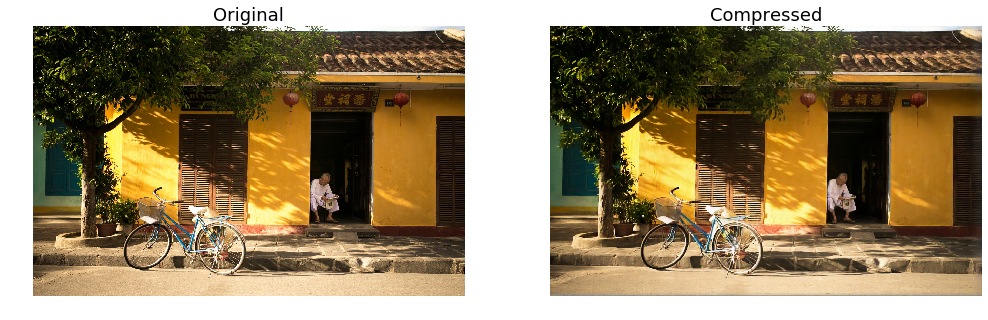

In [7]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(train_img_1)
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(encoded_1).numpy())
plt.axis("off")

plt.show()

In [9]:
from imageio import imwrite

clipped = np.squeeze(encoded_1.numpy())
clipped[clipped > 1] = 1
clipped[clipped < 0] = 0

clipped *= 255

clipped = clipped.astype(np.uint8)

im_path = "/homes/gf332/miracle-compession/img/poster/thong_vo_uncompressed_small_latent_space.png"

if not os.path.exists(im_path):
    imwrite(im_path, clipped)
else:
    print("{} already exists".format(im_path))

# Get results on the whole CLIC validation dataset

In [12]:
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

results = []

with tf.device("CPU:0"):
    for im_path in tqdm(valid_image_paths):

        image = tf.convert_to_tensor(load_and_process_image(valid_image_paths[0]))[None, ...]

        reconstruction = vae(image)
        reconstruction = tf.clip_by_value(reconstruction, 0., 1.)

        ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(image), reconstruction, 1.).numpy()[0]
        psnr = tf.image.psnr(image, reconstruction, max_val=1.0).numpy()[0]

        results.append((im_path, ms_ssim, psnr))

In [26]:
paths, ssims, psnrs = zip(*results)

ssim_mean = np.mean(ssims)
ssim_std = np.std(ssims)

psnrs_mean = np.mean(psnrs)
psnrs_std = np.std(psnrs)

print("MS-SSIM: {:.4f} \pm {:.4f}".format(ssim_mean, ssim_std))
print("PSNR: {:.2f} \pm {:.4f}".format(psnrs_mean, psnrs_std))

MS-SSIM: 0.9667 \pm 0.0001
PSNR: 32.49 \pm 0.0054


# Actual compression bit

In [8]:
def coded_sample(prior_loc, prior_scale, post_loc, post_scale, samp_tree, seed, use_codable=False):
    
    # Define functions to be used during the sampling procedure
    prop_trunc_samp = lambda a, b: truncnorm.ppf(np.random.uniform(), a, b)
    
    prop_log_mass = lambda a, b: np.log(norm.cdf(b, loc=prior_loc, scale=prior_scale) - \
                                        norm.cdf(a, loc=prior_loc, scale=prior_scale))
    
    log_diff = lambda x: normal_normal_log_diff(x, prior_loc, prior_scale, post_loc, post_scale)
    
    region_bound = lambda a, b: normal_normal_region_bound(a, 
                                                           b, 
                                                           prior_loc, 
                                                           prior_scale, 
                                                           post_loc, 
                                                           post_scale)
    
    prop_cdf = lambda x: norm.cdf(x, loc=prior_loc, scale=prior_scale)
    prop_inv_cdf = lambda x: norm.ppf(x, loc=prior_loc, scale=prior_scale)
    
    
    
    # Draw the sample
    if use_codable:
        return a_star_sample_codable(prop_log_mass=prop_log_mass, 
                                     log_diff=log_diff, 
                                     samp_tree=samp_tree,
                                     prop_cdf=prop_cdf,
                                     prop_inv_cdf=prop_inv_cdf,
                                     region_bound=region_bound,
                                     eps=1e-2)
    else:
        return a_star_sample(prop_trunc_samp=prop_trunc_samp, 
                              prop_log_mass=prop_log_mass, 
                              log_diff=log_diff, 
                              region_bound=region_bound, 
                              seed=seed, 
                              code_path=None)

In [9]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(valid_image_paths[0])
    res = vae.encode(tf.convert_to_tensor(train_img_1[None, ...]))
    
    res = vae.decode(res)

In [10]:
# Define constants
num_samples = 2**15

# Get all the stuff we will need to work with
with tf.device("CPU:0"):
    # Prior sufficient statistics
    p_mu_2 = vae.latent_priors[1].mean().numpy().flatten()
    p_sigma_2 = vae.latent_priors[1].stddev().numpy().flatten()
    p_mu_1 = vae.latent_priors[0].mean().numpy().flatten()
    p_sigma_1 = vae.latent_priors[0].stddev().numpy().flatten()

    # Posterior sufficient statistics
    q_mu_2 = vae.latent_posteriors[1].mean().numpy().flatten()
    q_sigma_2 = vae.latent_posteriors[1].stddev().numpy().flatten()
    q_mu_1 = vae.latent_posteriors[0].mean().numpy().flatten()
    q_sigma_1 = vae.latent_posteriors[0].stddev().numpy().flatten()

shape_2 = p_mu_2.shape
shape_1 = p_mu_1.shape

samp_tree = IntervalTree(num_nodes=num_samples)

samp_tree.depth

16

In [11]:
np.any(q_sigma_1[q_sigma_1 > p_sigma_1] - p_sigma_1[q_sigma_1 > p_sigma_1] > 1e-6)

False

In [12]:
correction_counter = 0

for i in tqdm(range(len(p_mu_2))):
    if np.abs(q_sigma_2[i] - p_sigma_2[i]) < 1e-3:
        q_sigma_2[i] -= 1e-3
        
        correction_counter += 1
        
print("Corrected: {}, {:.2f}%".format(correction_counter, 100 * correction_counter / len(p_mu_2)))


Corrected: 0, 0.00%


In [13]:
correction_counter = 0

for i in tqdm(range(len(p_mu_1))):
    if np.abs(q_sigma_1[i] - p_sigma_1[i]) < 1e-3:
        q_sigma_1[i] -= 1e-3
        
        correction_counter += 1
        
print("Corrected: {}, {:.2f}%".format(correction_counter, 100 * correction_counter / len(p_mu_1)))


Corrected: 8060, 1.14%


In [14]:
q_sigma_1[q_sigma_1 > p_sigma_1]

array([], dtype=float32)

In [16]:
import time

bad_latents = []
samples = []

np.random.seed(5)

for i in tqdm(range(len(p_mu_2))):
    
    if np.abs(p_mu_2[i] - q_mu_2[i]) / p_sigma_2[i] > 3.:
        bad_latents.append(i)
    else:
        start = time.time()
        samp = coded_sample(p_mu_2[i], p_sigma_2[i], q_mu_2[i], q_sigma_2[i], samp_tree, i, use_codable=False)
        total_time = time.time() - start
        if total_time > 0.5:
            print("idx {}, samp idx {}, time {:.4f}".format(i, samp[2], total_time))
        samples.append(samp)

KeyboardInterrupt: 

In [13]:
# v bad indices
# 79233
# 1213
# 33547
# 33291

np.random.seed(40)

i = 33547

#coded_sample(p_mu_2[i], p_sigma_2[i], q_mu_2[i], q_sigma_2[i], samp_tree)

In [14]:
print(p_mu_2[i], p_sigma_2[i], q_mu_2[i], q_sigma_2[i])

0.0 1.0 -0.23446664 0.52503806


In [42]:
import time

bad_latents = []
samples = []

np.random.seed(5)

for i in tqdm(range(len(p_mu_1))):
    
    if np.abs(p_mu_1[i] - q_mu_1[i]) / p_sigma_1[i] > 3.:
        bad_latents.append(i)
    else:
        start = time.time()
        samp = coded_sample(p_mu_1[i], p_sigma_1[i], q_mu_1[i], q_sigma_1[i], samp_tree, i, use_codable=False)
        total_time = time.time() - start
        if total_time > 0.5:
            print("idx {}, samp idx {}, time {:.4f}".format(i, samp[2], total_time))
        samples.append(samp)

FloatingPointError: divide by zero encountered in log

In [21]:
search_length = [len(x[2]) for x in samples]
plt.hist(search)

14

In [23]:
len(bad_latents)/ 196900

0.004296597257491112

In [8]:
with tf.device("CPU:0"):
    perc = np.percentile(tf.reshape(
        tf.abs(vae.latent_posteriors[0].mean() - vae.latent_priors[0].mean()) / vae.latent_priors[0].stddev(), 
        [-1]).numpy(), 99.5)

perc

3.064005249738698

In [23]:
bad = vae._latent_posteriors[0].stddev().numpy()[(vae._latent_posteriors[0].mean() > 3).numpy()]

In [39]:
np.prod(vae._latent_posteriors[0].mean().shape.as_list())

1541760

In [24]:
len(bad)

11041

In [17]:
with tf.device("CPU:0"):
    kls = tfd.kl_divergence(vae.latent_posteriors[0], vae.latent_priors[0])

In [18]:
np.argmax(kls.numpy())

139283

In [28]:
np.percentile(kls.numpy(), 100)

21.923460006713867

In [33]:
i = 241561

print(p_mu_1[i])
print(p_sigma_1[i])
print(q_mu_1[i])
print(q_sigma_1[i])

-0.0072919508
1.307096
19.276308
0.442652


In [35]:
kls = tfd.kl_divergence(vae._latent_posteriors[1], vae._latent_priors[1])

In [28]:
np.max(kls)

20.35207